# SSEN Substation Locations

## Context
SSEN's LV feeder data does not include any substation locations. We think being able to geo-locate the energy consumption is really valuable, so we want to try to fill that gap.

In our prototype, we used SSEN's LV Feeder -> Postcode mapping csv file to produce a "centroid" location for each substation. This is at best approximate, and (we later realised) in many cases totally wrong because we were not uniquely identifying substations properly.

Ultimately, what we want is a lookup table that matches the LV feeder's unique `dataset_id` to a lat/lng substation location, so that when we process the data we can look it up and add it in. This ADR explores the various ways we can do that and details our chosen solution.

*Note*: throughout this ADR I'm occasionally using locally downloaded files to speed things up, if you want to rerun it, adjust DOWNLOADS_PATH accordingly and download the files to that path from the URLs listed in each section.

In [10]:
# Importing libraries and defining constants
import pandas as pd
import re
import os
import io
import geopandas as gpd
import contextily as cx
import requests
import zipfile
import numpy as np
from pyproj import Transformer
from pyproj.transformer import TransformerGroup
from shapely import Point

# A regex for matching multiple spaces, used to reformat postcodes
SPACE_REGEX = re.compile(r"\s+")
DOWNLOADS_PATH = "~/Downloads"

## Data sources

First we get a variety of data sources and pre-process/clean them for use

### Feeder postcode lookup

SSEN publish a CSV file with the postcode(s) served by each LV feeder that lives alongside the smart meter data. They also include other grid topology data such as the secondary substation, HV feeder and primary substation. Importantly, the `_id` columns are concatenated to form the `dataset_id` which is a unique identifier for the LV feeder. You can take specific substrings of this to get unique ids for the other grid assets too.

The file can be found here: https://ssen-smart-meter-prod.portaljs.com/LV_FEEDER_LOOKUP/LV_FEEDER_LOOKUP.csv

In [2]:
feeder_postcodes_df = pd.read_csv(
    "https://ssen-smart-meter-prod.portaljs.com/LV_FEEDER_LOOKUP/LV_FEEDER_LOOKUP.csv",
    dtype=str, # Force all columns to be strings because some are integer-looking but have leading zeros
    storage_options={"User-Agent": "Mozilla/5.0"}, # Otherwise you get a 403 error
)

feeder_postcodes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419522 entries, 0 to 419521
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   dataset_id                 419522 non-null  object
 1   postcode                   419374 non-null  object
 2   primary_substation_id      419522 non-null  object
 3   primary_substation_name    419496 non-null  object
 4   hv_feeder_id               419522 non-null  object
 5   hv_feeder_name             416632 non-null  object
 6   secondary_substation_id    419522 non-null  object
 7   secondary_substation_name  410405 non-null  object
 8   lv_feeder_id               419522 non-null  object
 9   lv_feeder_name             98983 non-null   object
 10  total_mpan_count           407224 non-null  object
dtypes: object(11)
memory usage: 35.2+ MB


Note immediately:
- Not every row has a postcode
- Names for the various grid assets are optional

Later exploration of the data also shows us that some values are:
- Valid-looking, but not actually valid postcodes, e.g. DD2 0GZ, G77 7GB
- Postcode sectors or districts, e.g. G11
- Not perfectly formatted, with multiple spaces, varying capitalisation, etc

So, we clean it up a bit before using it:

In [3]:
# Reformat postcodes to make further cleaning easier
# It's quicker to just remove spaces completely than format them correctly
feeder_postcodes_df["standardised_postcode"] = feeder_postcodes_df["postcode"].str.strip().str.replace(SPACE_REGEX, "", regex=True).str.upper()

# Now Drop rows which are clearly invalid, or at least unusable for our purposes
feeder_postcodes_df.dropna(inplace=True, subset=["standardised_postcode"])
# Doesn't get rid of every invalid postcode, but 5 is the shortest valid UK postcode so
# it's on the safe side.
feeder_postcodes_df.drop(feeder_postcodes_df[feeder_postcodes_df.standardised_postcode.str.len() < 5].index, inplace=True)

# Format the NRN for the substation (a substring of the feeder's NRN) in the same way as other SSEN data
def substation_nrn(row):
    return f"{row["primary_substation_id"]}_{row["hv_feeder_id"]}_{row["secondary_substation_id"]}"

feeder_postcodes_df["substation_nrn"] = feeder_postcodes_df.apply(substation_nrn, axis=1)

feeder_postcodes_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 418721 entries, 0 to 419521
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   dataset_id                 418721 non-null  object
 1   postcode                   418721 non-null  object
 2   primary_substation_id      418721 non-null  object
 3   primary_substation_name    418696 non-null  object
 4   hv_feeder_id               418721 non-null  object
 5   hv_feeder_name             415836 non-null  object
 6   secondary_substation_id    418721 non-null  object
 7   secondary_substation_name  409623 non-null  object
 8   lv_feeder_id               418721 non-null  object
 9   lv_feeder_name             98704 non-null   object
 10  total_mpan_count           406459 non-null  object
 11  standardised_postcode      418721 non-null  object
 12  substation_nrn             418721 non-null  object
dtypes: object(13)
memory usage: 44.7+ MB


### ONSPD

The Office for National Statistics publish a CSV of postcodes every quarter which provides their centroid location, as well as various columns linking them to statistical geographies. We only want the locations, so that we have a way of going from postcode -> lat/lng

It's quite big as-is and is distributed in a zipfile without consistent file naming, so I did a bit of work to download it, unzip it and read in just what we want.

In [4]:
r = requests.get("https://www.arcgis.com/sharing/rest/content/items/265778cd85754b7e97f404a1c63aea04/data")
with zipfile.ZipFile(io.BytesIO(r.content)) as z:
    contents = z.namelist()
    filename = next(filter(lambda x: re.match(r'data/onspd_.*\.csv', x, flags=re.IGNORECASE), contents))
    with z.open(filename) as f:
        # Need to use Pandas for this because pyarrow doesn't support different null
        # values for different columns
        onspd_df = pd.read_csv(
            f,
            usecols=["pcd", "lat", "long"],
            dtype={"pcd": str, "lat": np.float64, "long": np.float64},
            # These are mentioned in the ONSPD docs
            na_values={"lat": "99.999999", "long": "0.000000"},
        )
        onspd_df.dropna(inplace=True)
        onspd_df["standardised_postcode"] = onspd_df["pcd"].str.replace(SPACE_REGEX, "", regex=True).str.upper()
onspd_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2682569 entries, 0 to 2706709
Data columns (total 4 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   pcd                    2682569 non-null  object 
 1   lat                    2682569 non-null  float64
 2   long                   2682569 non-null  float64
 3   standardised_postcode  2682569 non-null  object 
dtypes: float64(2), object(2)
memory usage: 102.3+ MB


### SSEN's Substation Data file

SSEN publish a file of general data about subsations, which includes locations, but sadly not their NRNs (yet)

In [5]:
substations_df = pd.read_csv(os.path.join(DOWNLOADS_PATH, "ssen-substation-data.csv"))
substations_gdf = gpd.GeoDataFrame(substations_df, geometry=gpd.points_from_xy(substations_df['Location X m'], substations_df["Location Y m"]), crs="EPSG:27700")
substations_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 121615 entries, 0 to 121614
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   Owner Type       121615 non-null  object  
 1   Owner Name       121568 non-null  object  
 2   Type             121615 non-null  object  
 3   Class            121615 non-null  object  
 4   Number           119569 non-null  object  
 5   Status           121615 non-null  object  
 6   Data Confidence  121615 non-null  object  
 7   Fence Type       121615 non-null  object  
 8   Operating Area   81706 non-null   object  
 9   Locality         81676 non-null   object  
 10  Location X mm    121551 non-null  float64 
 11  Location X m     121615 non-null  float64 
 12  Location Y mm    121551 non-null  float64 
 13  Location Y m     121615 non-null  float64 
 14  Leader Line      0 non-null       float64 
 15  Extent           47550 non-null   object  
 16  geometry    

### SSEN's Transformer Data file

This is another CSV file SSEN publish, with more electrical information about substations, but it also includes their location **and** their NRN.

Sadly, it only covers the SEPD license area, i.e. Southern England.

Zip file available here: https://data.ssen.co.uk/@ssen-distribution/transformer-load-model

See also experiments/ssen-substation-projections.ipynb - we realised the coordinates of
these need some fixing.

In [58]:
transformer_load_model_df = pd.read_csv(os.path.join(DOWNLOADS_PATH, "onedrive_1_01-08-2024/SEPD_transformers_open_data_with_nrn.csv"), usecols=["full_nrn", "latitude", "longitude"])
transformer_load_model_df.drop_duplicates(subset=["full_nrn"], inplace=True)
transformer_load_model_df.dropna(subset=["latitude", "longitude"], inplace=True)
transformer_load_model_gdf = gpd.GeoDataFrame(transformer_load_model_df, geometry=gpd.points_from_xy(transformer_load_model_df["longitude"], transformer_load_model_df["latitude"]), crs="EPSG:4326")

# Try to "fix" SSEN's badly converted locations in the transformer load model
# My hypothesis is that they started with EPSG:27700 and converted to EPSG:4326, but
# without the right datum/geoid or whatever you call it.
# We'll try turning them back into EPSG:27700 using something similar to their original
# conversion (but in reverse) to get something close to the original Eastings and
# Northings. Then try to convert those Easting and Northings back to EPSG:4326 using a
# more accurate transformation.

tg = TransformerGroup("EPSG:27700", "EPSG:4326")
# tg is a list of possible transformers. At first, I did not have the "best" one - pyproj
# knew about it and where to get it, but it needs downloading. It's the OSNT15 file:
# https://www.ordnancesurvey.co.uk/documents/gps/updated-transformations-uk-ireland-geoid-model.pdf
# See https://pyproj4.github.io/pyproj/stable/transformation_grids.html for more info
# I explored the outputs of all the transformers to see which one was closest to the
# original data and settled on the last one named "ballpark" as the most likely.

# This is probably the most reliable way to make sure the OSNT15 file is downloaded
# rather than trying to install it some other way
if not tg.best_available:
    tg.download_grids()
    tg = TransformerGroup("EPSG:27700", "EPSG:4326")
    assert tg.best_available

# Create the transformers we need from explicit proj pipeline strings
bad_transformer = Transformer.from_pipeline('proj=pipeline step proj=axisswap order=2,1 step proj=unitconvert xy_in=deg xy_out=rad step proj=tmerc lat_0=49 lon_0=-2 k=0.9996012717 x_0=400000 y_0=-100000 ellps=airy')
good_transformer = Transformer.from_pipeline('proj=pipeline step inv proj=tmerc lat_0=49 lon_0=-2 k=0.9996012717 x_0=400000 y_0=-100000 ellps=airy step proj=hgridshift grids=uk_os_OSTN15_NTv2_OSGBtoETRS.tif step proj=unitconvert xy_in=rad xy_out=deg step proj=axisswap order=2,1')

def fix_ssen_transforms(point):
    # Make sure we're messing with the Geometry types we expect
    assert isinstance(point, Point)
    # Note the y, x (lat, lon) order here - pyproj transformers respect the CRS' order
    easting, northing = bad_transformer.transform(point.y, point.x)
    x, y = good_transformer.transform(easting, northing)
    return Point(y, x)

transformer_load_model_gdf["geometry"] = transformer_load_model_gdf.geometry.apply(fix_ssen_transforms)
transformer_load_model_gdf.drop(columns=["latitude", "longitude"], inplace=True)
transformer_load_model_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 49972 entries, 0 to 5574312
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   full_nrn  49972 non-null  object  
 1   geometry  49972 non-null  geometry
dtypes: geometry(1), object(1)
memory usage: 1.1+ MB


In [54]:
transformer_load_model_gdf.head()

,full_nrn,geometry
0,1000_001_020,POINT (51.23229 -0.74358)
108,1000_001_030,POINT (51.22911 -0.73956)
216,1000_001_040,POINT (51.2298 -0.74062)
324,1000_001_080,POINT (51.22819 -0.74452)
432,1000_001_100,POINT (51.22849 -0.74317)


## Possible approaches

### Assign locations to feeder postcodes using ONSPD, then group and centroid those locations

This is what we did in our prototype, assign each feeder postcode a lat/lng (if we can match to ONSPD), then try to group by substation and find the centroid of all the points.

In [20]:
feeder_postcodes_df_with_locations = feeder_postcodes_df.merge(onspd_df, on="standardised_postcode", how="left")
feeder_postcodes_df_with_locations.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418721 entries, 0 to 418720
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   dataset_id                 418721 non-null  object 
 1   postcode                   418721 non-null  object 
 2   primary_substation_id      418721 non-null  object 
 3   primary_substation_name    418696 non-null  object 
 4   hv_feeder_id               418721 non-null  object 
 5   hv_feeder_name             415836 non-null  object 
 6   secondary_substation_id    418721 non-null  object 
 7   secondary_substation_name  409623 non-null  object 
 8   lv_feeder_id               418721 non-null  object 
 9   lv_feeder_name             98704 non-null   object 
 10  total_mpan_count           406459 non-null  object 
 11  standardised_postcode      418721 non-null  object 
 12  substation_nrn             418721 non-null  object 
 13  pcd                        41

As you can see from the counts, with our previous cleaning, this is pretty well-matched, we only have about 125 postcodes we can't match, out of 418k rows.

I've spot checked some of these on Google Maps and it can't find them either, so I assume there is some kind of data input error at fault here.

In [21]:
display(feeder_postcodes_df_with_locations[feeder_postcodes_df_with_locations["lat"].isna()])

,dataset_id,postcode,primary_substation_id,primary_substation_name,hv_feeder_id,hv_feeder_name,secondary_substation_id,secondary_substation_name,lv_feeder_id,lv_feeder_name,total_mpan_count,standardised_postcode,substation_nrn,pcd,lat,long
2755,001500701002,DD2 0GZ,0015,WEST KIRKTON,007,MAGDALENE KIRKTON,010,BEAULY AVENUE,02,NaN,52,DD20GZ,0015_007_010,NaN,NaN,NaN
16217,015701200501,G77 7GB,0157,STRATHCLYDE - HV IDNO,012,NEWTON MEARNS,005,MEARNSWOOD PLACE,01,MEARNSWOOD PLACE / LANE,25,G777GB,0157_012_005,NaN,NaN,NaN
16492,015900800501,EH20 7GB,0159,LOTHAIN - HV IDNO,008,LOANHEAD,005,ASHGROVE FIELDS,01,PHASE 2A PE,35,EH207GB,0159_008_005,NaN,NaN,NaN
16840,016000500501,FK8 5EE,0160,FIFE - HV IDNO,005,Denny,005,Mydub 1,01,"PE 2 HENDRY AVE, 12&18 BURNSIDE DR, 5&6 CHACEF...",64,FK85EE,0160_005_005,NaN,NaN,NaN
16910,016000700501,KY4 9FJ,0160,FIFE - HV IDNO,007,Gallows Knowe,005,Gallows Knowe,01,Ramsay Crescent,69,KY49FJ,0160_007_005,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417925,818200100506,SE8 9DX,8182,CREEKSIDE FAIRCHARM EST,001,CREEKSIDE FAIRCHARM EST,005,Creekside Faircharm est,06,NaN,59,SE89DX,8182_001_005,NaN,NaN,NaN
418174,823700100504,CT62 5DX,8237,BARRY WATERFRONT,001,WATERSIDE EAST,005,WATERSIDE EAST,04,NaN,48,CT625DX,8237_001_005,NaN,NaN,NaN
418207,823700101004,CF63 3BR,8237,BARRY WATERFRONT,001,WATERSIDE EAST,010,WATERSIDE WEST,04,NaN,24,CF633BR,8237_001_010,NaN,NaN,NaN
418209,823700101004,CF63 5BR,8237,BARRY WATERFRONT,001,WATERSIDE EAST,010,WATERSIDE WEST,04,NaN,24,CF635BR,8237_001_010,NaN,NaN,NaN


Next we need to merge that by substation and take a look at how sensible the postcodes are at that level:

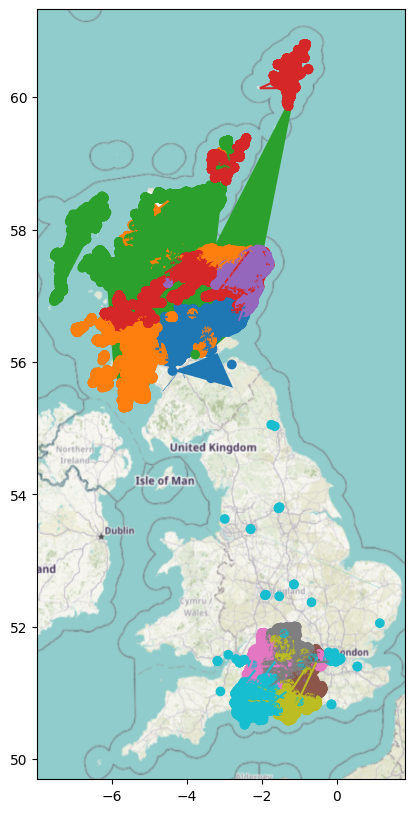

In [22]:
# Get rid of nulls
feeder_postcodes_df_with_locations.dropna(subset=["lat", "long"], inplace=True)
substation_areas_gdf = gpd.GeoDataFrame(
        feeder_postcodes_df_with_locations,
        geometry=gpd.points_from_xy(feeder_postcodes_df_with_locations.long, feeder_postcodes_df_with_locations.lat),
        crs="EPSG:4326"
    ).dissolve("substation_nrn").convex_hull.reset_index().rename(columns={0: "geometry"}).set_geometry("geometry")
ax = substation_areas_gdf.plot(column="substation_nrn", legend=False, figsize=(10, 10))
cx.add_basemap(ax, crs=substation_areas_gdf.crs.to_string(), attribution=False)
# Alternatively, you can use substation_areas_gdf.explore(column="substation_nrn", legend=False)
# to get an interactive map with tooltips


From this we can see lots of problems:
- Huge areas for a single substation, e.g. 0572_000_025, 7951_001_005
- Substations located outside SSEN's license areas, e.g. 8401_001_005
- Substation areas with massively outlying postcodes, e.g. 7602_003_400
- Areas that are actually just two postcodes very far apart, e.g. 7604_002_340

Last time in our prototype, we chose to ignore substations we couldn't locate, so we could continue to follow that process here and ignore these kinds of issues with some heuristics. 

After some experimentation, I settled on including:
 
- Points (i.e. single postcodes)
- Lines that are less than 100m long (i.e. two postcodes not that far apart)
- Polygons that are less than 10,000 sqm and on average no more than 100m from each other (i.e. three or more postcodes, not that far from each other)

In [62]:
# We'll need to measure areas and lengths, so we need to convert to a suitable projection
substation_areas_gdf_bng = substation_areas_gdf.to_crs("EPSG:27700")
{
    "total substations": len(substation_areas_gdf_bng),
    "simple point locations": len(substation_areas_gdf_bng[substation_areas_gdf_bng.geometry.type == "Point"]),
    "line locations": len(substation_areas_gdf_bng[substation_areas_gdf_bng.geometry.type == "LineString"]),
    "< 100m line locations": len(substation_areas_gdf_bng[(substation_areas_gdf_bng.geometry.type == "LineString") & (substation_areas_gdf_bng.geometry.length < 100)]),
    "polygon locations": len(substation_areas_gdf_bng[substation_areas_gdf_bng.geometry.type == "Polygon"]),
    "< 10,000sqm / 1km polygon locations": len(substation_areas_gdf_bng[(substation_areas_gdf_bng.geometry.type == "Polygon") & (substation_areas_gdf_bng.geometry.area < 10000) & (substation_areas_gdf_bng.geometry.length / substation_areas_gdf_bng.geometry.count_coordinates() < 100)]),
}

{'total substations': 91027,
 'simple point locations': 50104,
 'line locations': 10552,
 '< 100m line locations': 1367,
 'polygon locations': 30371,
 '< 10,000sqm / 1km polygon locations': 2375}

In [63]:
sensible_susbstation_areas_gdf = substation_areas_gdf_bng[
    (substation_areas_gdf_bng.geometry.type == "Point") |
    ((substation_areas_gdf_bng.geometry.type == "LineString") & (substation_areas_gdf_bng.geometry.length < 100)) |
    ((substation_areas_gdf_bng.geometry.type == "Polygon") & (substation_areas_gdf_bng.geometry.length / substation_areas_gdf_bng.geometry.count_coordinates() < 100))
]
sensible_susbstation_areas_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 55560 entries, 3 to 91026
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   substation_nrn  55560 non-null  object  
 1   geometry        55560 non-null  geometry
dtypes: geometry(1), object(1)
memory usage: 1.3+ MB


This doesn't get rid of locations outside the DNO license area though, of which there are still quite a few. I'm not confident enough to include them either at this stage. Therefore, we need to exclude them as well.

In [27]:
# I tried using the geojson but geopandas doesn't like the shepd one
# Note the shapefiles come in different projections, so we need to convert them to a common one
# we're still using epsg:27700 here so that we can do a dwithin query in meters
sepd_gdf = gpd.read_file("https://data-api.ssen.co.uk/dataset/68c1b190-6c71-44e8-bf24-03c2d85c825e/resource/22aebde1-b710-492d-a674-c4f2cc2debcb/download/sse_license-areas.zip", layer="SEPD").to_crs("EPSG:27700")
shepd_gdf = gpd.read_file("https://data-api.ssen.co.uk/dataset/68c1b190-6c71-44e8-bf24-03c2d85c825e/resource/22aebde1-b710-492d-a674-c4f2cc2debcb/download/sse_license-areas.zip", layer="SHEPD")
license_areas_gdf = gpd.GeoDataFrame(pd.concat([sepd_gdf, shepd_gdf], ignore_index=True))

These are the official shapefiles for SSEN's license areas. They looks good initially, but at a closer look (e.g. around Yarmouth on the Isle of White) you can see it doesn't quite match the true extent of land. This is likely to cause some false negatives where substations are right on the border.

Ultimately, that's probably okay up to a certain distance - there's bound to be some fuzziness about ownership, so we'll give a little bit of leeway.

In [28]:
# Include everything within 1km of the license areas, as a way to work around the fact
# that neither license areas nor postcodes are perfect and so there are probably some
# validly located ones pretty close to the boundary anyway
sensible_substation_areas_inside_license_areas_gdf = sensible_susbstation_areas_gdf.sjoin(license_areas_gdf, how="left", predicate="dwithin", distance=1000)
sensible_substation_areas_inside_license_areas_gdf.info()

# I explored these to tweak the distance parameter using this:
# sensible_susbstation_areas_inside_license_areas_gdf[sensible_susbstation_areas_inside_license_areas_gdf["index_right"].isna()].explore()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 55357 entries, 3 to 91026
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   substation_nrn  55357 non-null  object  
 1   geometry        55357 non-null  geometry
 2   index_right     55143 non-null  float64 
 3   License         55143 non-null  object  
dtypes: float64(1), geometry(1), object(2)
memory usage: 2.1+ MB


In [29]:
sensible_substation_areas_inside_license_areas_gdf.dropna(subset=["index_right"], inplace=True)
sensible_substation_areas_inside_license_areas_gdf.drop(columns=["index_right", "License"], axis=1, inplace=True)
sensible_substation_areas_inside_license_areas_gdf["centroid"] = sensible_substation_areas_inside_license_areas_gdf.centroid
postcode_centroid_lookup = sensible_substation_areas_inside_license_areas_gdf[["substation_nrn", "centroid"]].set_geometry("centroid").set_index("substation_nrn").to_crs("EPSG:4326")

This gives us our final lookup table based on postcodes:

In [30]:
postcode_centroid_lookup.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 55143 entries, 0002_003_005 to 8900_099_005
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   centroid  55143 non-null  geometry
dtypes: geometry(1)
memory usage: 861.6+ KB


### Matching to the transformer data file

For the SEPD area, the best approach should be to match substations via their NRN to the actual locations SSEN publish.

These will be more accurate than any postcode centroid we could produce

In [59]:
# Reload this file because we don't need all the transformations we did for postcode
# lookup
smart_meter_substations = pd.read_csv(
    "https://ssen-smart-meter-prod.portaljs.com/LV_FEEDER_LOOKUP/LV_FEEDER_LOOKUP.csv",
    dtype=str, # Force all columns to be strings because some are integer-looking but have leading zeros
    storage_options={"User-Agent": "Mozilla/5.0"}, # Otherwise you get a 403 error
)
smart_meter_substations["substation_nrn"] = smart_meter_substations.apply(substation_nrn, axis=1)
smart_meter_substations.drop_duplicates(subset=["substation_nrn"], inplace=True)
smart_meter_substations.set_index("substation_nrn", inplace=True)
transformer_load_model_gdf.set_index("full_nrn", inplace=True)
transformer_load_model_lookup = smart_meter_substations.join(transformer_load_model_gdf, how="left")
transformer_load_model_lookup.dropna(subset=["geometry"], inplace=True)
transformer_load_model_lookup = transformer_load_model_lookup[["geometry"]]
transformer_load_model_lookup = gpd.GeoDataFrame(transformer_load_model_lookup, geometry=transformer_load_model_lookup["geometry"], crs="EPSG:4326")
transformer_load_model_lookup.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 41522 entries, 1000_001_030 to 8079_001_005
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  41522 non-null  geometry
dtypes: geometry(1)
memory usage: 1.6+ MB


This is probably about what we can expect - the transformer load model may contain things which don't match exactly to the definiton of a secondary substation in the smart meter data. We can make this our second lookup table:
How does this compare to the postcode substation lookup?

Lets see how our two methods stack up

1. How many substations not matched by the transformer data _are_ matched by the sensible postcode data?
2. Where are those on a map?
3. Which ones are not matched by either?

In [60]:
{
    "total substations": len(smart_meter_substations),
    "located by transformer lookup": len(smart_meter_substations.index.intersection(transformer_load_model_lookup.index)),
    "located by postcode lookup": len(smart_meter_substations.index.intersection(postcode_centroid_lookup.index)),
    "located by both": len(smart_meter_substations.index.intersection(transformer_load_model_lookup.index.intersection(postcode_centroid_lookup.index))),
    "missing locations in both": len(smart_meter_substations.index.difference(transformer_load_model_lookup.index.union(postcode_centroid_lookup.index)))
}

{'total substations': 91050,
 'located by transformer lookup': 41522,
 'located by postcode lookup': 55143,
 'located by both': 17453,
 'missing locations in both': 11838}

So we're doing quite good - we can locate approx 80,000 out of 90,000, and we can improve on the location of about 17,500 using SSEN's open data, so it's worth doing!

Lets see where those are, to get a better idea of where we our data will be better or worse.

In [66]:
# Mapping the inverse of the counts above to see the bad data and then the overlap to
# see the improvement.
missing_from_postcodes = transformer_load_model_lookup.loc[transformer_load_model_lookup.index.difference(postcode_centroid_lookup.index)]
missing_from_transformers = postcode_centroid_lookup.loc[postcode_centroid_lookup.index.difference(transformer_load_model_lookup.index)]
shared_in_both = transformer_load_model_lookup.loc[transformer_load_model_lookup.index.intersection(postcode_centroid_lookup.index)]

# Overlay this with another (larger) SSEN dataset of substations, styled so we can see overlaps
# as another way of checking against the "truth"
ssen_substation_data_df = pd.read_csv(os.path.join(DOWNLOADS_PATH, "ssen-substation-data.csv"), usecols=["Location X m", "Location Y m", "Type", "Class", "Number", "Status"], dtype={"Type": str, "Class": str, "Number": str, "Status": str, "Location X m": np.float64, "Location Y m": np.float64})
ssen_substation_data_gdf = gpd.GeoDataFrame(ssen_substation_data_df, geometry=gpd.points_from_xy(ssen_substation_data_df["Location X m"], ssen_substation_data_df["Location Y m"]), crs="EPSG:27700").to_crs("EPSG:4326")
ssen_substation_data_gdf = ssen_substation_data_gdf[~(ssen_substation_data_gdf["Type"] == "Primary")]

# Running this locally I explore the whole dataset, but it's too large to commit the
# output to GitHub, so clip the output to a smaller area
example_rect = bbox = [-2.45, 50.7, -2.35, 50.9]
map = missing_from_postcodes.clip(example_rect).explore(color="blue", marker_kwds={"radius": 5}, location=(50.7962, -2.4189), zoom_start=13)
missing_from_transformers.clip(example_rect).explore(m=map, color="red", marker_kwds={"radius": 5})
shared_in_both.clip(example_rect).explore(m=map, color="green", marker_kwds={"radius": 5})
ssen_substation_data_gdf.clip(example_rect).explore(m=map, color="orange", marker_kwds={"radius": 10, "fill": False})

This looks pretty good, if a little surprising:

- (Thanks to our re-projection), substations align with the other source of truth quite well (here I'm referring to SSEN's other substation data, but also alignment with things marked on OpenStreetMap)
- We can locate a lot of stuff in Southern England which would otherwise be badly located via just postcodes
- We have to use postcodes in Scotland, because we can't use the other dataset without ids
- Surprisingly, postcodes do give us some locations even in the South which we wouldn't get otherwise - not sure why these are missing from the other dataset
- Also surprisingly, there are officially located substations outside of the license areas - I'm not really sure what these are, but we presumably can trust these locations


### Future work: matching to the nearest substation in the substation data file

Can we use this other substation data to provide a more accurate location for our fuzzy postcodes

- Take sensible postcode data
- Join to substation data based on sjoin_nearest with a threshold? Or perhaps using NLP on the naming and numbering?
- See how many we join

I don't have time for this right now, and I'm not sure how good it will be, but it might be interesting to explore.

# Conclusion

Our prototype's approach of postcode centroid-ing has quite a few issues, because the
postcodes assigned to feeders (and / or the substations feeders are assigned to) are not
always logical. This means the substation locations are often not very trustworthy 
(even once we identify substation properly).

We can improve on those locations significantly in the south using additional data
instead of postcodes, but that data has its own issues and needs the coordinates fixing
before it's reasonably accurate.

In Scotland, we don't have any such data we can use at the moment, although there is
hope SSEN could add identifiers to it.

Therefore, where we have to use postcode data, we can be strict with it to try to make
sure the centroids we calculate are reasonably accurate, or at least, not obviously 
really bad.

Ultimately, we'll use both, with a preference for the transformer load model's locations
to get the best coverage, We'll also push SSEN to add NRNs to their substation data file
to get even better coverage in the future.
